In [1]:
from rawio.IO import *
import ROOT 
import root_numpy

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline
import pandas as pd
pd.set_option("display.max_row", 100)
import numpy as np

import math
import sys
import os, os.path 
import fnmatch
import glob

Welcome to JupyROOT 6.24/06


In [2]:
supersim = os.environ["CDMS_SUPERSIM"]
# Pull in Warren's detector-channel drawing utility from SuperSim
sys.path.append(os.path.join(supersim,"CDMSscripts","validation"))
import detectorLayout

In [3]:
# Function to convert our C-style char[] strings to RDataFrame std::strings
# Why doesn't ROOT do this automatically (or have an option to do so)?
ROOT.gInterpreter.Declare("""
std::string convertToString(const ROOT::VecOps::RVec<Char_t>& vec) {
    std::string s;
    size_t length = vec.size();
    for (size_t i = 0; vec[i]!='\\0'; ++i) {   // Takes care of arrays with extra NUL at end
        s += vec[i];
        }
    return s;
    }
 """)

True

In [4]:
## NOTE: This version is for ROOT 6.24 and earlier; in ROOT 6.26, use rdf.Redefine() 
def cast_columns(rdf):
    """Convert char[] (C-style string) TBranches to strings, with new column names
       Usage: fixed_rdf = cast_columns(ROOT::RDataFrame(.....))
       After calling data = fixed_rdf.AsNumpy(), the original column name can be restored with
       data['Branch'] = data.pop('Branch_cast')
    """
    for column in rdf.GetColumnNames():
        if rdf.GetColumnType(column) == "ROOT::VecOps::RVec<Char_t>":
            rdf = rdf.Define(f"{column}_cast", f"convertToString({column})")
            # NOTE: No way to rename or delete a column before 6.26; do it later via Numpy 
    return rdf

In [5]:
def cast_array(data):
    """Convert RDataFrame array columns to Numpy arrays, can replace in situ
       Usage: numpy['Branch'] = cast_array(numpy['Branch'])
    """
    casted_row = []
    for row in data:
        casted_row.append([i for i in row])
    return np.array(casted_row)

In [32]:
def getPhononHits(file):
    """Extract useful phonon hit information from specified file
       Usage: numpyData = getSharingData('myRootFile.root')
    """
    branches = ['EventNum','TrkStep','PName','Charge','X3','Y3','Z3','ChanNum','Time3','KE','Yield','Weight']
    rdf = cast_columns(ROOT.RDataFrame("G4SimDir/mczip0", file, branches))
    data = rdf.AsNumpy(branches+['PName_cast'])
    data['PName'] = data.pop('PName_cast')
    data['Rsq'] = data['X3']**2+data['Y3']**2
    data['R3'] = np.sqrt(data['Rsq'])
    return data

In [7]:
files = { '0mm': 'data/CDMSlite_time/CDMSlite-10keV-R0mm_51231013_0000.root',
          '5mm': 'data/CDMSlite_time/CDMSlite-10keV-R5mm_51231013_0000.root',
          '10mm': 'data/CDMSlite_time/CDMSlite-10keV-R10mm_51231013_0000.root',
          '15mm': 'data/CDMSlite_time/CDMSlite-10keV-R15mm_51231013_0000.root',
          '20mm': 'data/CDMSlite_time/CDMSlite-10keV-R20mm_51231013_0000.root',
          '25mm': 'data/CDMSlite_time/CDMSlite-10keV-R25mm_51231013_0000.root',
          '30mm': 'data/CDMSlite_time/CDMSlite-10keV-R30mm_51231013_0000.root',
        }

In [8]:
# Will want to get channel names from G4SettingsInfo/Geometry.ChanName list
phChans = ['PA','PB','PC','PD']

In [9]:
def isPhonon(hits):
    return ((hits['Charge']==0) & (hits['ChanNum']>=0))

def timeSlice(hits,tmin,tmax):
    """Time range in us"""
    return ((tmin*1e3<hits['Time3']) & (hits['Time3']<tmax*1e3))

In [10]:
def energyPlot(hits,label):
    detectorLayout.draw(chaninfo)
    plt.scatter(hits['X3'][isPhonon(hits)]*1e3, hits['Y3'][isPhonon(hits)]*1e3,
                c=hits['Yield'][isPhonon(hits)], s=1)
    plt.title(f"CDMSlite 10 keV ER @ {label}, Phonon hits")
    plt.xlabel("[mm]")
    cax = plt.axes([0.91, 0.12, 0.025, 0.76])
    bar = plt.colorbar(cax=cax)
    bar.set_label("Energy absorbed [eV]")
    plt.savefig(f"CDMSlite_R{label}-hits.png")

In [11]:
def timePlot(hits,label,tmin,tmax):
    detectorLayout.draw(chaninfo)
    select = (timeSlice(hits,tmin,tmax) & isPhonon(hits))
    x = hits['X3'][select]*1e3
    y = hits['Y3'][select]*1e3
    T = hits['Time3'][select]/1e3
    plt.scatter(x,y,c=T,s=1)
    plt.title(f"CDMSlite 10 keV ER @ {label}, Phonon hit times")
    plt.xlabel("[mm]")
    cax = plt.axes([0.91, 0.12, 0.025, 0.76])
    bar = plt.colorbar(cax=cax)
    bar.set_label("Phonon Hit Time [us]")
    plt.savefig(f"CDMSlite_R{label}-times.png")

In [12]:
# Time range for slice should be in us
def timeSlicePlot(hits,label,tmin,tmax):
    select = (timeSlice(hits,tmin,tmax) & isPhonon(hits))
    x = hits['X3'][select]*1e3
    y = hits['Y3'][select]*1e3
    E = hits['Yield'][select]*1e3
    detectorLayout.draw(chaninfo)
    plt.scatter(x,y,c=E,s=1,vmin=0.,vmax=10.)   # Fixed energy range in meV
    plt.title(f"CDMSlite 10 keV ER @ {label}, {tmax} us")
    plt.xlabel("[mm]")
    cax = plt.axes([0.91, 0.12, 0.025, 0.76])
    bar = plt.colorbar(cax=cax)
    bar.set_label("Energy absorbed [meV]")
    plotname = f"CDMSlite_R{label}-slice{tmax}us.png"
    plt.savefig(plotname)
    return plotname

In [13]:
# Scatterplot of hits vs. position in a time slice (us units)
def timeSliceFrame(hits,label,**kwargs):
    tmin = kwargs['tmin']
    tmax = kwargs['tmax']
    select = (timeSlice(hits,tmin,tmax) & isPhonon(hits))
    x = hits['X3'][select]*1e3     # m to mm
    y = hits['Y3'][select]*1e3     # m to mm
    E = hits['Yield'][select]*1e3  # eV to meV
    ### plt.scatter(x,y,c=E,s=1,vmin=0.,vmax=10.)   # Fixed energy range in meV
    plt.title(f"CDMSlite 10 keV ER @ {label}, {tmax} us")
    scat = plt.gca().collections
    if len(scat)==0:
        plt.scatter(x,y,c=E,s=1,vmin=0.,vmax=10.)   # Need to make first set of points
    else:
        scat[0].set_offsets(np.vstack([x,y]).transpose())
    return plt.gcf()

In [14]:
# Histogram of energy vs. radius in time slice (us), for movie
def energySliceFrame(hits,label,**kwargs):
    tmin = kwargs['tmin']
    tmax = kwargs['tmax']
    select = (timeSlice(hits,tmin,tmax) & isPhonon(hits))
    E = hits['Yield'][select]      # eV to meV
    plt.hist(hits['R3'][select]*1e3,weights=E,bins=40,range=(0.,40.),log=False)
    plt.title(f"CDMSlite 10 keV ER @ (15,0,0), {tmax} us")
    plt.xlabel("Hit Radius [mm]")
    plt.ylabel("Energy Absorbed [eV]")
    return plt.gcf()

In [15]:
def energySliceVsR(hits,label,tmin,tmax):
    energySliceFrame(hits,label,tmin=tmin,tmax=tmax)
    plt.savefig(f"CDMSlite-R{label}_Energy-{tmax}us.png")

In [16]:
# Histogram of energy vs. radius in time slice (us), for movie
def energyVsRsq(hits,label,**kwargs):
    tmin = kwargs['tmin']
    tmax = kwargs['tmax']
    select = (timeSlice(hits,tmin,tmax) & isPhonon(hits))
    E = hits['Yield'][select]      # eV to meV
    plt.hist(hits['Rsq'][select]*1e6,weights=E,log=False)
    plt.title(f"CDMSlite 10 keV ER @ (15,0,0), {tmax} us")
    plt.xlabel("Hit Radius Squared [mm^2]")
    plt.ylabel("Energy Absorbed [eV]")
    plt.savefig(f"CDMSlite-R{label}_EvsRsq-{tmax}us.png")

In [50]:
hits = getPhononHits(files['15mm'])
chaninfo = detectorLayout.loadGeometry(files['15mm'])

Extracting geometry data...


Text(0, 0.5, 'Phonon Energy / 1 us bin [eV]')

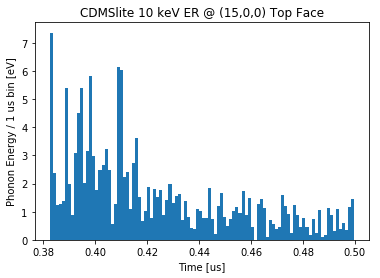

In [54]:
tzcut = ((hits['Time3']<500) & (hits['Charge']==0) & (hits['Z3']>0))
plt.hist(hits['Time3'][tzcut]/1e3,weights=hits['Yield'][tzcut]*hits['Weight'][tzcut],bins=100,log=False)
plt.title("CDMSlite 10 keV ER @ (15,0,0) Top Face")
plt.xlabel("Time [us]")
plt.ylabel("Phonon Energy / 1 us bin [eV]")

Text(0, 0.5, 'Phonon Energy / 1 us bin [eV]')

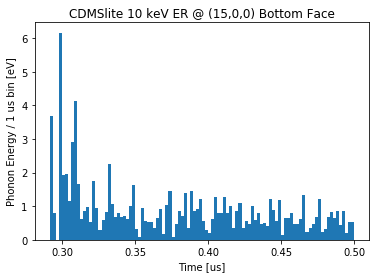

In [55]:
tzcut = ((hits['Time3']<500) & (hits['Charge']==0) & (hits['Z3']<0))
plt.hist(hits['Time3'][tzcut]/1e3,weights=hits['Yield'][tzcut]*hits['Weight'][tzcut],bins=100,log=False)
plt.title("CDMSlite 10 keV ER @ (15,0,0) Bottom Face")
plt.xlabel("Time [us]")
plt.ylabel("Phonon Energy / 1 us bin [eV]")

Text(0, 0.5, 'Hit Times / 1 us bin [eV]')

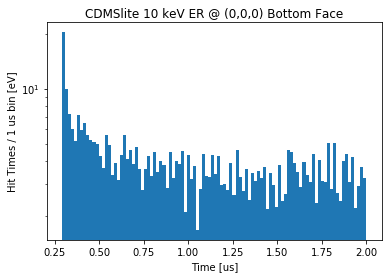

In [56]:
tzcut = ((hits['Time3']<2000) & (hits['Charge']==0) & (hits['Z3']<0))
plt.hist(hits['Time3'][tzcut]/1e3,weights=hits['Yield'][tzcut]*hits['Weight'][tzcut],bins=100,log=True)
plt.title("CDMSlite 10 keV ER @ (0,0,0) Bottom Face")
plt.xlabel("Time [us]")
plt.ylabel("Hit Times / 1 us bin [eV]")

Text(0.5, 1.0, 'CDMSlite 10 keV ER @ (0,0,0) Bottom Face')

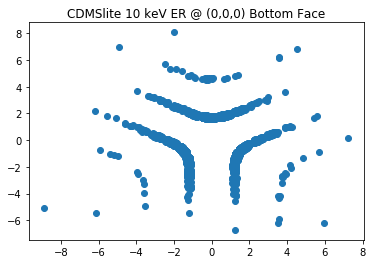

In [49]:
tzcut = ((hits['Time3']<2000) & (hits['Charge']==0) & (hits['Z3']<0))
plt.scatter(hits['X3'][tzcut]*1e3,hits['Y3'][tzcut]*1e3)
plt.title("CDMSlite 10 keV ER @ (0,0,0) Bottom Face")

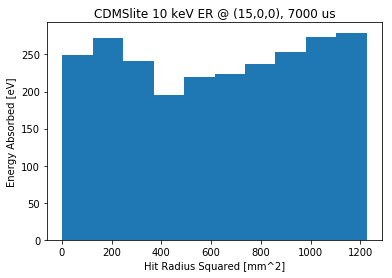

In [84]:
energyVsRsq(hits,'15mm',tmin=0,tmax=7000)

Generating detector diagram...


'CDMSlite_R15mm-slice30us.png'

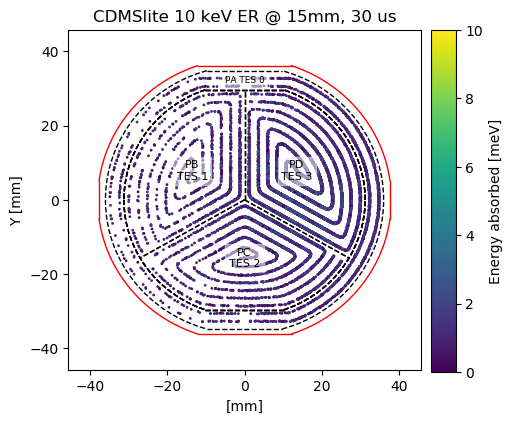

In [30]:
timeSlice(hits,'15mm',20,30)

In [54]:
def detonly():
    detectorLayout.draw(chaninfo)
    plt.xlabel("[mm]")
    cax = plt.axes([0.91, 0.12, 0.025, 0.76])
    bar = plt.colorbar(cax=cax)
    bar.set_label("Energy absorbed [meV]")
    return plt.gcf(),

def hitFrame(i):
    return timeSliceFrame(hits,'15mm',tmin=i*2,tmax=(i+1)*2),

Generating detector diagram...


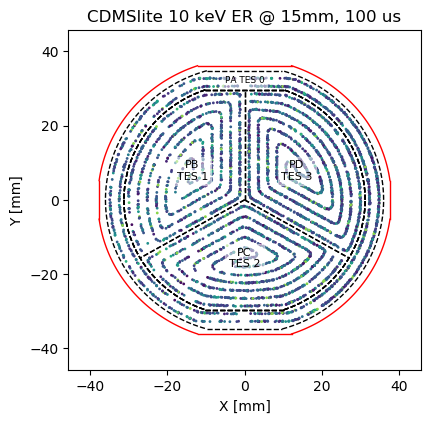

In [57]:
detectorLayout.draw(chaninfo)
nframes = 50
###plt.subplots_adjust(top=1, bottom=0, left=0, right=1)
anim = animation.FuncAnimation(plt.gcf(), hitFrame, frames=nframes,
                               interval=500., repeat=True, repeat_delay=200., blit=True)
anim.save('CDMSlite-15mm_movie.gif',writer="pillow")

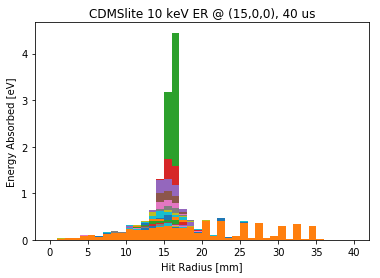

In [60]:
def EFrame(i):
    return energySliceFrame(hits,'15mm',tmin=i*2,tmax=(i+1)*2),

# Movie of energy absorption integrated around phi
nframes = 20
###plt.subplots_adjust(top=1, bottom=0, left=0, right=1)
anim = animation.FuncAnimation(plt.gcf(), EFrame, frames=nframes,
                               interval=500., repeat=True, repeat_delay=200., blit=True)
anim.save('CDMSlite-15mm_EvsR.gif',writer="pillow")

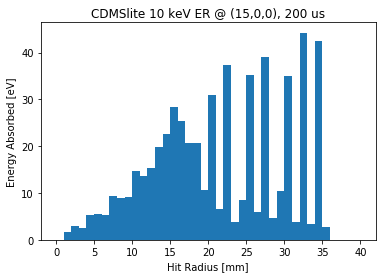

In [63]:
energySliceVsR(hits,'15mm',0,200)